In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("../../../data/data_taxi_central_based.parquet")
df = df[df['POLYLINE_LENGTH'] == 41]
df

,TRIP_ID,ORIGIN_CALL,TAXI_ID,TIMESTAMP,POLYLINE_LENGTH,LON,LAT
index,,,,,,,
1284,1372638793620000571,2002.0,20000571,1372638793,41,-8.574705,41.142717
1285,1372638793620000571,2002.0,20000571,1372638808,41,-8.574696,41.142726
1286,1372638793620000571,2002.0,20000571,1372638823,41,-8.574687,41.142726
1287,1372638793620000571,2002.0,20000571,1372638838,41,-8.574678,41.142708
1288,1372638793620000571,2002.0,20000571,1372638853,41,-8.574687,41.142708
...,...,...,...,...,...,...,...
83401453,1404155073620000099,4690.0,20000099,1404155613,41,-8.620533,41.145957
83401454,1404155073620000099,4690.0,20000099,1404155628,41,-8.620542,41.145957
83401455,1404155073620000099,4690.0,20000099,1404155643,41,-8.619741,41.146119


In [3]:
import timesfm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)].


In [4]:
df_lon = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LAT'])
df_lat = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LON'])

In [5]:
tfm_lat = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=20,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
tfm_lon = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=20,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
df_lat = df_lat.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lat_test = df_lat.groupby('TRIP_ID', group_keys=False).tail(20)
df_lat_train = df_lat.drop(df_lat_test.index)

In [8]:
df_lon = df_lon.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lon_test = df_lon.groupby('TRIP_ID', group_keys=False).tail(20)
df_lon_train = df_lon.drop(df_lat_test.index)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler_lat = MinMaxScaler()
df_lat_train['LAT'] = scaler_lat.fit_transform(df_lat_train[['LAT']])

scaler_lon = MinMaxScaler()
df_lon_train['LON'] = scaler_lon.fit_transform(df_lon_train[['LON']])

In [10]:
df_lat_train['TIMESTAMP'] = pd.to_datetime(df_lat_train['TIMESTAMP'], unit='s')
df_lon_train['TIMESTAMP'] = pd.to_datetime(df_lon_train['TIMESTAMP'], unit='s')

In [11]:
df_lon_train = df_lon_train.rename(columns={'TIMESTAMP': 'ds', 'LON': 'y', 'TRIP_ID': 'unique_id'})
df_lat_train = df_lat_train.rename(columns={'TIMESTAMP': 'ds', 'LAT': 'y', 'TRIP_ID': 'unique_id'})

In [12]:
forecast_df_lon = tfm_lon.forecast_on_df(
    inputs=df_lon_train,
    freq="15s",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [13]:
forecast_df_lat = tfm_lon.forecast_on_df(
    inputs=df_lat_train,
    freq="15s",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [14]:
forecast_df_lon_keep = forecast_df_lon[['unique_id', 'ds', 'timesfm-q-0.9']]

In [15]:
forecast_df_lat_keep = forecast_df_lat[['unique_id', 'ds', 'timesfm-q-0.9']]

In [16]:
forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])

C:\Users\Nikola\AppData\Local\Temp\ipykernel_16204\3587103272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
C:\Users\Nikola\AppData\Local\Temp\ipykernel_16204\3587103272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])


In [17]:
forecast_df_lat_keep = forecast_df_lat_keep.rename(columns={'timesfm-q-0.9': 'LAT_PREDICTED'})
forecast_df_lon_keep = forecast_df_lon_keep.rename(columns={'timesfm-q-0.9': 'LON_PREDICTED'})

In [18]:
forecast_df_lat_keep = forecast_df_lat_keep.sort_values(['unique_id', 'ds'])
forecast_df_lat_keep = forecast_df_lat_keep.groupby('unique_id').tail(1)

forecast_df_lon_keep = forecast_df_lon_keep.sort_values(['unique_id', 'ds'])
forecast_df_lon_keep = forecast_df_lon_keep.groupby('unique_id').tail(1)

In [19]:
df_lon_test = df_lon_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lon_test = df_lon_test.sort_values(['unique_id', 'ds'])
df_lon_test = df_lon_test.groupby('unique_id').tail(1)

df_lat_test = df_lat_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lat_test = df_lat_test.sort_values(['unique_id', 'ds'])
df_lat_test = df_lat_test.groupby('unique_id').tail(1)

In [20]:
result_lat = df_lat_test.merge(forecast_df_lat_keep, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon_keep, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [21]:
from evaluation_script import haversine_distance

In [22]:
result['DISTANCE_DELTA_SEPARATED'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row['LAT_PREDICTED'], row['LON_PREDICTED']), axis=1)

In [23]:
result['DISTANCE_DELTA_SEPARATED'].mean()

np.float64(2.053931598274781)

In [24]:
result['DISTANCE_DELTA_SEPARATED'].median()

np.float64(1.7421047654658441)

In [25]:
result.to_csv("result.csv", index=False)

In [26]:
forecast_df_lat

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1372638793620000571,2013-07-01 00:38:28,0.289636,0.287266,0.288103,0.288786,0.289284,0.289636,0.289921,0.290180,0.290703,0.291638
1,1372638793620000571,2013-07-01 00:38:43,0.288468,0.285940,0.286759,0.287465,0.288044,0.288468,0.288868,0.289291,0.290085,0.291479
2,1372638793620000571,2013-07-01 00:38:58,0.287473,0.285106,0.285816,0.286473,0.287031,0.287473,0.287913,0.288426,0.289318,0.290937
3,1372638793620000571,2013-07-01 00:39:13,0.286858,0.284672,0.285312,0.285897,0.286404,0.286858,0.287298,0.287820,0.288874,0.290750
4,1372638793620000571,2013-07-01 00:39:28,0.286242,0.284291,0.284811,0.285323,0.285794,0.286242,0.286715,0.287332,0.288467,0.290571
...,...,...,...,...,...,...,...,...,...,...,...,...
136475,1404157914620000488,2014-06-30 20:00:54,0.488055,0.460025,0.469842,0.476526,0.482522,0.488055,0.493967,0.500909,0.509529,0.523811
136476,1404157914620000488,2014-06-30 20:01:09,0.486274,0.457431,0.467585,0.474438,0.480472,0.486274,0.492366,0.499484,0.508424,0.523061
136477,1404157914620000488,2014-06-30 20:01:24,0.484342,0.454778,0.465399,0.472419,0.478566,0.484342,0.490697,0.498146,0.507212,0.522100
136478,1404157914620000488,2014-06-30 20:01:39,0.484072,0.454787,0.465316,0.472181,0.478286,0.484072,0.490336,0.497624,0.506698,0.521479


In [27]:
columns = ['timesfm-q-0.1', 'timesfm-q-0.2', 'timesfm-q-0.3', 'timesfm-q-0.4', 'timesfm-q-0.5', 'timesfm-q-0.6', 'timesfm-q-0.7', 'timesfm-q-0.8', 'timesfm-q-0.9']

In [28]:
for column in columns:
    forecast_df_lat[column] = scaler_lat.inverse_transform(forecast_df_lat[[column]])
    forecast_df_lon[column] = scaler_lon.inverse_transform(forecast_df_lon[[column]])

In [29]:
forecast_df_lat = forecast_df_lat.sort_values(['unique_id', 'ds'])
forecast_df_lat = forecast_df_lat.groupby('unique_id').tail(1)

forecast_df_lon = forecast_df_lon.sort_values(['unique_id', 'ds'])
forecast_df_lon = forecast_df_lon.groupby('unique_id').tail(1)

In [30]:
result_lat = df_lat_test.merge(forecast_df_lat, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [31]:
result

,unique_id,ds_x_x,LAT,ds_y_x,timesfm_x,timesfm-q-0.1_x,timesfm-q-0.2_x,timesfm-q-0.3_x,timesfm-q-0.4_x,timesfm-q-0.5_x,...,timesfm_y,timesfm-q-0.1_y,timesfm-q-0.2_y,timesfm-q-0.3_y,timesfm-q-0.4_y,timesfm-q-0.5_y,timesfm-q-0.6_y,timesfm-q-0.7_y,timesfm-q-0.8_y,timesfm-q-0.9_y
0,1372638793620000571,1372639393,41.142636,2013-07-01 00:43:13,0.287715,41.142719,41.142853,41.142960,41.143055,41.143154,...,0.735886,-8.599424,-8.589869,-8.584729,-8.580961,-8.578316,-8.576289,-8.574795,-8.573832,-8.572600
1,1372641068620000178,1372641668,41.124366,2013-07-01 01:21:08,0.212432,41.119930,41.125290,41.128326,41.130589,41.132710,...,0.600251,-8.606570,-8.605021,-8.603922,-8.602910,-8.601873,-8.600748,-8.599443,-8.597731,-8.594587
2,1372656887620000167,1372657487,41.150844,2013-07-01 05:44:47,0.351365,41.147278,41.148628,41.149715,41.150837,41.151985,...,0.140027,-8.723721,-8.706600,-8.696557,-8.688789,-8.681811,-8.674873,-8.667569,-8.659448,-8.648573
3,1372657987620000623,1372658587,41.154570,2013-07-01 06:03:07,0.493178,41.165375,41.167759,41.169285,41.170540,41.171658,...,0.152097,-8.718079,-8.704770,-8.696086,-8.688241,-8.679714,-8.669991,-8.657927,-8.643268,-8.624678
4,1372660930620000571,1372661530,41.120118,2013-07-01 06:52:10,0.304243,41.111217,41.125332,41.133457,41.139641,41.145447,...,0.681658,-8.609119,-8.602303,-8.597115,-8.592128,-8.587734,-8.583840,-8.579588,-8.574241,-8.564931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,1404155056620000206,1404155656,41.151906,2014-06-30 19:14:16,0.353982,41.151531,41.151875,41.152065,41.152214,41.152344,...,0.467673,-8.643918,-8.637352,-8.632801,-8.628738,-8.624902,-8.621502,-8.618445,-8.615232,-8.610179
6820,1404155073620000099,1404155673,41.146920,2014-06-30 19:14:33,0.284467,41.133934,41.137447,41.139496,41.141109,41.142704,...,0.485240,-8.623188,-8.622816,-8.622533,-8.622211,-8.621850,-8.621477,-8.621069,-8.620665,-8.620096
6821,1404155819620000242,1404156419,41.171085,2014-06-30 19:26:59,0.408957,41.156063,41.157822,41.158813,41.159443,41.159973,...,0.441057,-8.664278,-8.651898,-8.643378,-8.636139,-8.629524,-8.623030,-8.616484,-8.608995,-8.596552
6822,1404157331620000343,1404157931,41.157612,2014-06-30 19:52:11,0.333845,41.146908,41.147640,41.148224,41.148842,41.149555,...,0.438332,-8.639633,-8.635764,-8.633593,-8.631777,-8.629998,-8.627758,-8.625045,-8.621679,-8.617480


In [32]:
df_lat_test

,unique_id,ds,LAT
index,,,
1324,1372638793620000571,1372639393,41.142636
6569,1372641068620000178,1372641668,41.124366
23524,1372656887620000167,1372657487,41.150844
19767,1372657987620000623,1372658587,41.154570
57958,1372660930620000571,1372661530,41.120118
...,...,...,...
83349437,1404155056620000206,1404155656,41.151906
83401457,1404155073620000099,1404155673,41.146920
83362183,1404155819620000242,1404156419,41.171085


In [33]:
for col in columns:
    result[f'DISTANCE_DELTA_SEPARATED_{col}'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row[f'{col}_x'], row[f'{col}_y']), axis=1)

In [34]:
for col in columns:
    print(f"Column: {col}   Mean: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()}    Median: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()}")

Column: timesfm-q-0.1   Mean: 2.116357805105032    Median: 1.7893385944186138
Column: timesfm-q-0.2   Mean: 1.8125815288261757    Median: 1.5433918150356771
Column: timesfm-q-0.3   Mean: 1.6735482481811008    Median: 1.422676662674904
Column: timesfm-q-0.4   Mean: 1.5965407645164638    Median: 1.351383691896456
Column: timesfm-q-0.5   Mean: 1.5620372156657722    Median: 1.3129447255518316
Column: timesfm-q-0.6   Mean: 1.575246044306723    Median: 1.3288002737435274
Column: timesfm-q-0.7   Mean: 1.6366542087847478    Median: 1.3847224739770418
Column: timesfm-q-0.8   Mean: 1.766398925756005    Median: 1.4864425592336397
Column: timesfm-q-0.9   Mean: 2.053931598274781    Median: 1.7421047654658441


In [35]:
import matplotlib.pyplot as plt

In [36]:
stats = []
for col in columns:
    mean_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()
    median_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()
    label = col.replace("timesfm-", "")
    stats.append({"quantile": label, "mean": mean_val, "median": median_val})

df_stats = pd.DataFrame(stats)

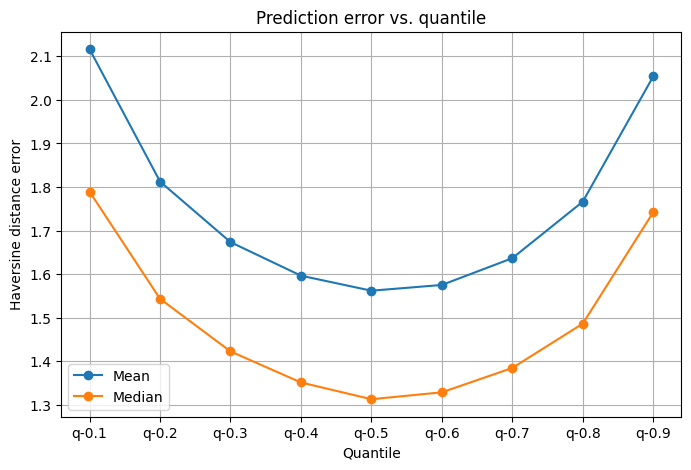

In [37]:
plt.figure(figsize=(8,5))
plt.plot(df_stats["quantile"], df_stats["mean"], marker="o", label="Mean")
plt.plot(df_stats["quantile"], df_stats["median"], marker="o", label="Median")
plt.xlabel("Quantile")
plt.ylabel("Haversine distance error")
plt.title("Prediction error vs. quantile")
plt.legend()
plt.grid(True)
plt.show()